In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json("clean_dataset_3inpclass_v3.json")

In [4]:
df.sample(3)

,id,elapsed_sec,output,model,type
24260,/home/harinarayan.j/human_vs_machine/train-dir...,3.842294,The sun set slowly over the ocean as I gazed o...,llama,mw_mh
21800,/home/harinarayan.j/human_vs_machine/train-dir...,2.736177,The newest innovation in cycling has taken off...,llama,mw_mh
73259,/home/harinarayan.j/human_vs_machine/train-dir...,4.648576,ADVANCE NOTICE Revolutionizing Mortgage and Lo...,llama,hw_mp


In [5]:
df.drop(['id', 'elapsed_sec'], axis=1, inplace=True)
df.sample(3)

,output,model,type
72272,"In American Thinkers yesterday, I warned my re...",llama,hw_mp
32161,"WASHINGTON D.C., DC - Congressman Robert Johns...",mistral,mw
75332,"Eeven if you neveer watch Hindii moives, you m...",llama,hw_mp


In [6]:
cols = df.columns.tolist()
cols[1], cols[2] = cols[2], cols[1]
df = df[cols]

In [7]:
df.sample(3)

,output,type,model
76086,This waste of taxpare dollars is truly galling...,hw_mp,llama
53226,<|assistant|> # *During break* Student: Oh man...,hw_mp,falcon
97690,... END POLISHED TEXT Thank you. Your task h...,hw_mp,aya


In [8]:
df.shape

(115426, 3)

In [9]:
df = df.sample(frac=1)

In [10]:
df.shape

(115426, 3)

In [11]:
df.sample(5)

,output,type,model
59934,She wasn't beautiful; she was interesting. Her...,hw_mp,llama
26142,Presidents Hank Thompsons handshake with Forei...,mw_mh,llama
4861,World stock exchanges are in turmoill today as...,mw_mh,mistral
110142,<|assistant|> In the ancient agricultural soci...,mw,falcon
50432,<|assistant|> An unfolding class- action lawsu...,hw_mp,falcon


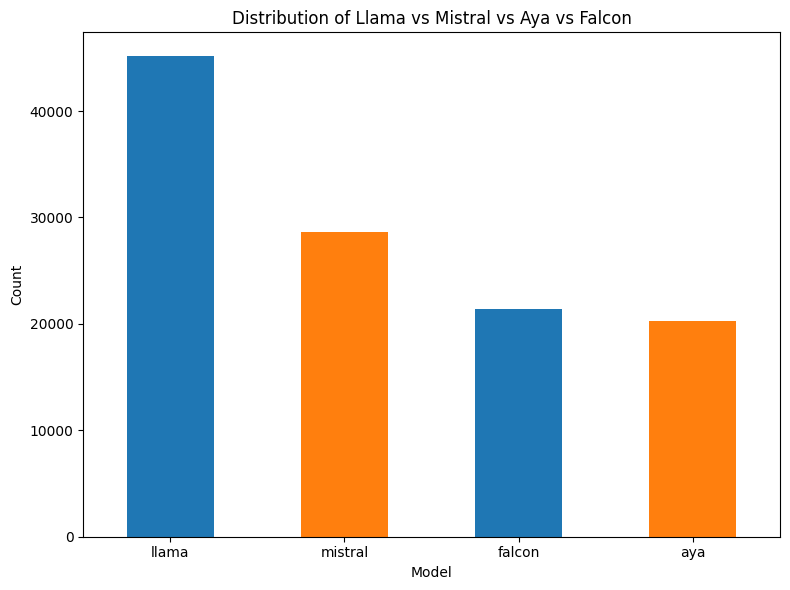

model
llama      45135
mistral    28592
falcon     21385
aya        20314
Name: count, dtype: int64


In [12]:
model_counts = df['model'].value_counts()

plt.figure(figsize=(8, 6))
model_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Llama vs Mistral vs Aya vs Falcon')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(model_counts)

In [13]:
import pandas as pd

counts = df['model'].value_counts()
print(counts)

min_count = counts.min()

df_balanced = df.groupby('model', group_keys=False).apply(
    lambda x: x.sample(n=min_count, random_state=42)
).reset_index(drop=True)

print(df_balanced['model'].value_counts())


model
llama      45135
mistral    28592
falcon     21385
aya        20314
Name: count, dtype: int64
model
aya        20314
falcon     20314
llama      20314
mistral    20314
Name: count, dtype: int64


C:\Users\Venkat\AppData\Local\Temp\ipykernel_108416\3520079534.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('model', group_keys=False).apply(


In [14]:
df = df_balanced

In [15]:
df.shape

(81256, 3)

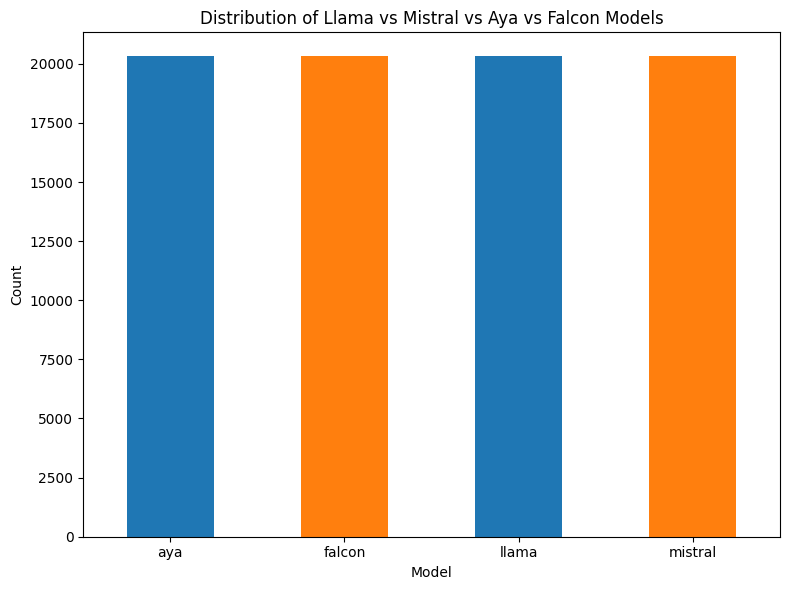

model
aya        20314
falcon     20314
llama      20314
mistral    20314
Name: count, dtype: int64


In [16]:
model_counts = df['model'].value_counts()

plt.figure(figsize=(8, 6))
model_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Llama vs Mistral vs Aya vs Falcon Models')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(model_counts)

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...


c:\Users\Venkat\nlp_llm\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Venkat\nlp_llm\env\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



MODEL COMPARISON RESULTS
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8872     0.8903  0.8872    0.8882
      Random Forest    0.8276     0.8335  0.8276    0.8295
            XGBoost    0.8825     0.8865  0.8825    0.8838
           LightGBM    0.8724     0.8764  0.8724    0.8738


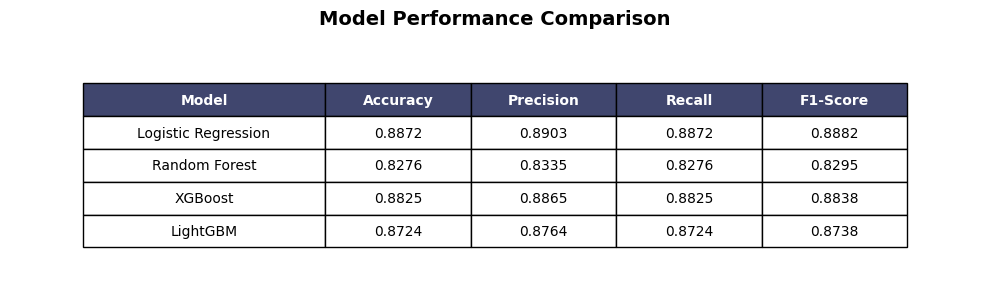

In [17]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -------------------------------
# Label Encoding
# -------------------------------
le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])

le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
X_type = df['type']
y = df['model']

# -------------------------------
# Train-test split
# -------------------------------
X_train_text, X_test_text, X_train_type, X_test_type, y_train, y_test = train_test_split(
    X_text, X_type, y, test_size=0.1, random_state=42, stratify=y
)

# -------------------------------
# TF-IDF (Sparse)
# -------------------------------
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# -------------------------------
# Combine Sparse TF-IDF + type feature
# -------------------------------
X_train = hstack([X_train_tfidf, X_train_type.values.reshape(-1, 1)])
X_test = hstack([X_test_tfidf, X_test_type.values.reshape(-1, 1)])

# -------------------------------
# MODELS
# -------------------------------
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        tree_method='hist',     # required for sparse input
        n_estimators=300,
        max_depth=6
    ),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# -------------------------------
# TRAINING LOOP
# -------------------------------
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# -------------------------------
# RESULTS TABLE
# -------------------------------
results_df = pd.DataFrame(results).round(4)

print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# -------------------------------
# PLOT TABLE
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.25, 0.15, 0.15, 0.15, 0.15]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Header color
for i in range(len(results_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



🎲 Running Randomized Search for Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Params for Logistic Regression: {'C': np.float64(1.844347898661638), 'solver': 'saga'}

MODEL COMPARISON RESULTS (After Randomized Search CV)
              Model                                Best Params  Accuracy  Precision  Recall  F1-Score
Logistic Regression {'C': 1.844347898661638, 'solver': 'saga'}    0.8881     0.8911  0.8881    0.8891


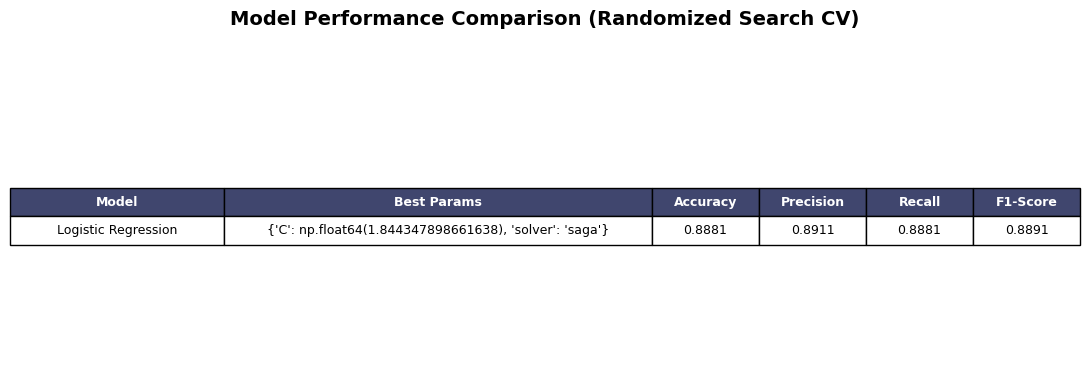

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from scipy.sparse import hstack
import matplotlib.pyplot as plt

le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])

le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
X_type = df['type']
y = df['model']

X_train_text, X_test_text, X_train_type, X_test_type, y_train, y_test = train_test_split(
    X_text, X_type, y, test_size=0.1, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

X_train = hstack([X_train_tfidf, X_train_type.values.reshape(-1, 1)])
X_test = hstack([X_test_tfidf, X_test_type.values.reshape(-1, 1)])


from scipy.stats import uniform, randint

models = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {
            'C': uniform(0.01, 10),
            'solver': ['lbfgs', 'saga']
        }
    )
}


scorer = make_scorer(f1_score, average='weighted')
results = []

for name, (model, param_dist) in models.items():
    print(f"\n🎲 Running Randomized Search for {name}...")
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,           # number of random combos to test
        scoring=scorer,
        cv=3,                # fewer folds to save RAM/time
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"✅ Best Params for {name}: {random_search.best_params_}")
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Best Params': random_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })


results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS (After Randomized Search CV)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


fig, ax = plt.subplots(figsize=(11, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=results_df.values, 
    colLabels=results_df.columns,
    cellLoc='center', 
    loc='center',
    colWidths=[0.2, 0.4, 0.1, 0.1, 0.1, 0.1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.6)

for i in range(len(results_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Comparison (Randomized Search CV)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



🎲 Running Randomized Search for Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

MODEL COMPARISON RESULTS (Randomized Search CV, No 'type')
              Model                                Best Params  Accuracy  Precision  Recall  F1-Score
Logistic Regression {'C': 1.844347898661638, 'solver': 'saga'}     0.881     0.8843   0.881    0.8821


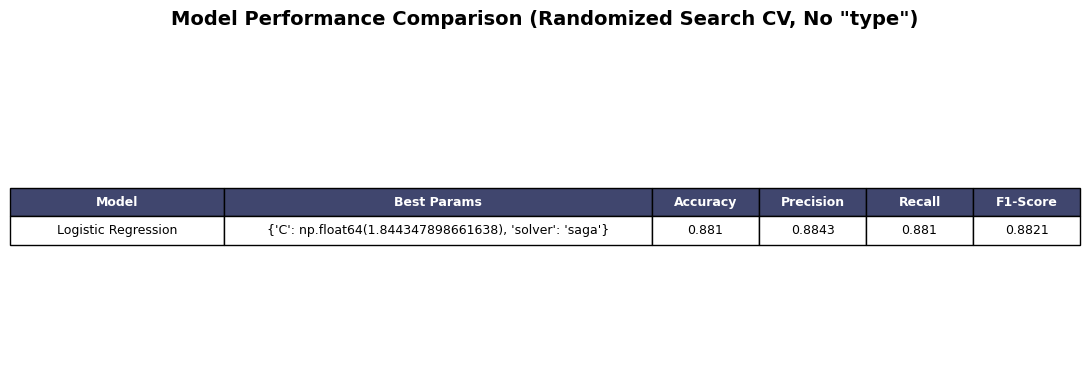

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt


le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
y = df['model']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)


models = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {'C': uniform(0.01, 10), 'solver': ['lbfgs', 'saga']}
    )
}


scorer = make_scorer(f1_score, average='weighted')
results = []

for name, (model, param_dist) in models.items():
    print(f"\n🎲 Running Randomized Search for {name}...")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        scoring=scorer,
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train_tfidf, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)

    results.append({
        'Model': name,
        'Best Params': random_search.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results).round(4)

print("\n" + "="*90)
print("MODEL COMPARISON RESULTS (Randomized Search CV, No 'type')")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

fig, ax = plt.subplots(figsize=(11, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.2, 0.4, 0.1, 0.1, 0.1, 0.1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.6)

for i in range(len(results_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Comparison (Randomized Search CV, No "type")', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])

le_model = LabelEncoder()
df['model'] = le_model.fit_transform(df['model'])

X_text = df['output']
X_type = df['type']
y = df['model']

X_train_text, X_test_text, X_train_type, X_test_type, y_train, y_test = train_test_split(
    X_text, X_type, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

X_train = np.hstack([X_train_tfidf.toarray(), X_train_type.values.reshape(-1, 1)])
X_test = np.hstack([X_test_tfidf.toarray(), X_test_type.values.reshape(-1, 1)])

print("Training Logistic Regression with best parameters...")
best_model = LogisticRegression(
    C=3.347086111390218, 
    solver='saga',
    max_iter=2000,
    random_state=42
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*70)
print("BEST MODEL RESULTS - Logistic Regression")
print("="*70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*70)

print("\nSaving model and preprocessing objects...")
joblib.dump(best_model, 'logistic_regression_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le_type, 'label_encoder_type.pkl')
joblib.dump(le_model, 'label_encoder_model.pkl')

print("✓ Model saved as: logistic_regression_model.pkl")
print("✓ Vectorizer saved as: tfidf_vectorizer.pkl")
print("✓ Type encoder saved as: label_encoder_type.pkl")
print("✓ Model encoder saved as: label_encoder_model.pkl")

print("\n" + "="*70)
print("LOADING MODEL EXAMPLE")
print("="*70)
print("To load and use the model later:")
print("""
# Load the saved objects
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
le_type = joblib.load('label_encoder_type.pkl')
le_model = joblib.load('label_encoder_model.pkl')

# Make predictions on new data
# new_text = ["your text here"]
# new_type = [0]  # encoded type value
# X_new_tfidf = vectorizer.transform(new_text)
# X_new = np.hstack([X_new_tfidf.toarray(), np.array(new_type).reshape(-1, 1)])
# prediction = model.predict(X_new)
# predicted_model = le_model.inverse_transform(prediction)
""")
print("="*70)

Training Logistic Regression with best parameters...

BEST MODEL RESULTS - Logistic Regression
Accuracy:  0.8432
Precision: 0.8460
Recall:    0.8432
F1-Score:  0.8443

Saving model and preprocessing objects...
✓ Model saved as: logistic_regression_model.pkl
✓ Vectorizer saved as: tfidf_vectorizer.pkl
✓ Type encoder saved as: label_encoder_type.pkl
✓ Model encoder saved as: label_encoder_model.pkl

LOADING MODEL EXAMPLE
To load and use the model later:

# Load the saved objects
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
le_type = joblib.load('label_encoder_type.pkl')
le_model = joblib.load('label_encoder_model.pkl')

# Make predictions on new data
# new_text = ["your text here"]
# new_type = [0]  # encoded type value
# X_new_tfidf = vectorizer.transform(new_text)
# X_new = np.hstack([X_new_tfidf.toarray(), np.array(new_type).reshape(-1, 1)])
# prediction = model.predict(X_new)
# predicted_model = le_model.inverse_transform(predi